### Final Project

In [78]:
# Step 1: Setup and Library Imports

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# MIDI processing
import pretty_midi

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# File paths
DATASET_PATH = "./NN_midi_files_extended"  # Update this if you move the dataset
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
TEST_DIR = os.path.join(DATASET_PATH, "test")
DEV_DIR = os.path.join(DATASET_PATH, "dev")

# For reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Setup complete")


Setup complete


### Preprocessing MIDI Files into Numerical Sequences

In [79]:
# Step 2: MIDI Parsing and Note Sequence Extraction

def extract_note_sequence_with_duration(file_path):
    """
    Extracts a sequence of [pitch, duration] pairs from a MIDI file.
    Skips drums and returns a list of pairs for all instruments.
    """
    try:
        midi_data = pretty_midi.PrettyMIDI(file_path)
        notes = []
        for instrument in midi_data.instruments:
            if not instrument.is_drum:
                for note in instrument.notes:
                    duration = note.end - note.start
                    notes.append([note.pitch, duration])
        return notes
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def extract_note_sequence_with_velocity(file_path):
    """
    Extracts [pitch, duration, velocity] features from a MIDI file.
    Skips drums and returns a list of pairs for all instruments.
    """
    try:
        midi_data = pretty_midi.PrettyMIDI(file_path)
        notes = []
        for instrument in midi_data.instruments:
            if not instrument.is_drum:
                for note in instrument.notes:
                    duration = note.end - note.start
                    notes.append([note.pitch, duration, note.velocity])
        return notes
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Trasportaion function for pitch values in note pairs


def transpose_sequence_triplet(note_triplets, semitone_shift):
    """
    Transpose pitch in a [pitch, duration, velocity] sequence.
    """
    return [
        [min(max(pitch + semitone_shift, 0), 127), duration, velocity]
        for pitch, duration, velocity in note_triplets
    ]

def collect_dataset_triplet(folder_path, augment=False):
    sequences = []
    labels = []

    composers = sorted(os.listdir(folder_path))
    for composer in composers:
        composer_path = os.path.join(folder_path, composer)
        if os.path.isdir(composer_path):
            for file in tqdm(os.listdir(composer_path), desc=f"Processing {composer}"):
                if file.endswith(".mid"):
                    file_path = os.path.join(composer_path, file)
                    note_seq = extract_note_sequence_with_velocity(file_path)
                    if note_seq:
                        if augment:
                            for shift in [-2, -1, 0, 1, 2]:
                                transposed = transpose_sequence_triplet(note_seq, shift)
                                sequences.append(transposed)
                                labels.append(composer)
                        else:
                            sequences.append(note_seq)
                            labels.append(composer)
    return sequences, labels


# Load training data with velocity
# uncomment two lines for reverting back to Train_DIR only
# train_sequences, train_labels = collect_dataset_triplet(TRAIN_DIR, augment=True)
# print(f" Collected {len(train_sequences)} training sequences from {len(set(train_labels))} composers")

### Combined Sequence:
# Step 16A: Load from both train and dev folders

train_sequences_1, train_labels_1 = collect_dataset_triplet(TRAIN_DIR, augment=True)
train_sequences_2, train_labels_2 = collect_dataset_triplet(DEV_DIR, augment=True)

# Combine the two sets
combined_sequences = train_sequences_1 + train_sequences_2
combined_labels = train_labels_1 + train_labels_2

print(f"Combined training samples: {len(combined_sequences)} from {len(set(combined_labels))} composers")


Processing bach:   0%|          | 0/43 [00:00<?, ?it/s]

Processing chopin:   0%|          | 0/42 [00:00<?, ?it/s]/Users/falasoul/.pyenv/versions/3.10.13/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Processing schumann: 100%|██████████| 4/4 [00:00<00:00, 76.53it/s]


Combined training samples: 2020 from 9 composers


In [80]:
from collections import Counter
print("Training label distribution:", Counter(train_labels))


Training label distribution: Counter({'bach': 210, 'byrd': 210, 'hummel': 210, 'bartok': 205, 'chopin': 205, 'handel': 205, 'mendelssohn': 205, 'mozart': 205, 'schumann': 190})


Class Distribution looks ok, no need to re-work dataset balance. 

### Class Distripution

Warning:
means that the MIDI file has meta-events (like tempo or time signature changes) stored on a track other than track 0, which violates the MIDI standard for type 0 or type 1 files. However, pretty_midi still parses the file and extracts notes correctly.

### Sequence Padding and Label Encoding

To make the MIDI note sequences compatible with CNNs and LSTMs, we need to:
- Pad all sequences to the same length (e.g., 500 notes).
- Encode composer labels into integers.
- Normalize note values to a fixed range (optional but helpful for CNNs).

In [81]:
# Step 3: Sequence Padding and Label Encoding

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Configuration: Sequence length
#SEQUENCE_LENGTH = 500  # You can adjust this later based on model performance
SEQUENCE_LENGTH = 1500
# Pad note sequences to the same length
# We'll pad with 0s at the end (post-padding) for shorter sequences
### uncomment to revert to normal LSTM
#X_train = pad_sequences(train_sequences, maxlen=config["sequence_length"], padding='post', truncating='post', dtype='float32')
### Padding for combined Dataset 
X_train = pad_sequences(combined_sequences, maxlen=config["sequence_length"], padding='post', truncating='post', dtype='float32')

# Normalize pitch only (first column)
# Normalize all 3 features
X_train[:, :, 0] = X_train[:, :, 0] / 127.0            # pitch
X_train[:, :, 1] = np.clip(X_train[:, :, 1], 0, 5) / 5.0  # duration
X_train[:, :, 2] = X_train[:, :, 2] / 127.0            # velocity

# Encode labels
## revert back to train_labels if needed 
y_train = label_encoder.fit_transform(combined_labels)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=SEED)

print(f"Final input shape: {X_train.shape} — includes pitch + duration + Velocity")

print(f"Final training shape: {X_train.shape}")
print(f"Final validation shape: {X_val.shape}")


Final input shape: (1818, 1500, 3) — includes pitch + duration + Velocity
Final training shape: (1818, 1500, 3)
Final validation shape: (202, 1500, 3)


### Model Building and Configuration for further enhancements iterations

#### Configuration Block

In [83]:
# Step 4A: Define Training Configuration

config = {
    "sequence_length": SEQUENCE_LENGTH,               # Updated in earlier stage to 1500
    "num_classes": len(composer_mapping),
    
    # CNN config
    "cnn_filters_1": 64,
    "cnn_kernel_1": 5,
    "cnn_filters_2": 128,
    "cnn_kernel_2": 3,
    "cnn_pool_size": 2,

    # LSTM
    "lstm_units": 256,

    # Training setup
    "dropout_rate": 0.4,
    "batch_size": 32,
    "epochs": 50,
    "learning_rate": 0.001,

    # Paths
    "checkpoint_path": "composer_cnn_lstm_best_model.h5",
    "history_log": "training_history.csv"
}

print("Updated configuration loaded")



Updated configuration loaded


### Model CNN+LSTM

In [84]:
from tensorflow.keras.layers import Bidirectional
# Step 4B: Define CNN + LSTM Model Builder
def build_bidirectional_cnn_lstm_model(config):
    model = Sequential()
    model.add(Input(shape=(config["sequence_length"], 3)))  # 3 features: pitch, duration, velocity

    # CNN Layers
    model.add(Conv1D(filters=config["cnn_filters_1"], kernel_size=config["cnn_kernel_1"], activation='relu'))
    model.add(MaxPooling1D(pool_size=config["cnn_pool_size"]))
    model.add(BatchNormalization())

    model.add(Conv1D(filters=config["cnn_filters_2"], kernel_size=config["cnn_kernel_2"], activation='relu'))
    model.add(MaxPooling1D(pool_size=config["cnn_pool_size"]))
    model.add(BatchNormalization())

    # Bidirectional LSTM
    model.add(Bidirectional(LSTM(config["lstm_units"], return_sequences=False)))
    model.add(Dropout(config["dropout_rate"]))

    # Output layer
    model.add(Dense(config["num_classes"], activation='softmax'))

    # Compile
    optimizer = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Step 4B: Define CNN + LSTM Model Builder


def build_cnn_lstm_model(config):
    model = Sequential()
    

    # Input: 2 features: pitch + duration – reshape required later
    model.add(Input(shape=(config["sequence_length"], 3)))  # 
    
    # First CNN layer
    model.add(Conv1D(filters=config["cnn_filters_1"], kernel_size=config["cnn_kernel_1"], activation='relu'))
    model.add(MaxPooling1D(pool_size=config["cnn_pool_size"]))
    model.add(BatchNormalization())


    # Second CNN layer
    model.add(Conv1D(filters=config["cnn_filters_2"], kernel_size=config["cnn_kernel_2"], activation='relu'))
    model.add(MaxPooling1D(pool_size=config["cnn_pool_size"]))
    model.add(BatchNormalization())


    # LSTM Layer
    model.add(LSTM(config["lstm_units"], return_sequences=False))
    model.add(Dropout(config["dropout_rate"]))

    # Output Layer
    model.add(Dense(config["num_classes"], activation='softmax'))

    # Compile Model
    optimizer = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Reshape input for CNN: (samples, sequence_length, 1)
# X_train_reshaped = X_train[..., np.newaxis]
# X_val_reshaped = X_val[..., np.newaxis]

model = build_bidirectional_cnn_lstm_model(config)
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)              │ (None, 1496, 64)       │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 748, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 748, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 746, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 373, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 373, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 512)            │       788,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 819,593 (3.13 MB)

 Trainable params: 819,209 (3.13 MB)

 Non-trainable params: 384 (1.50 KB)

- We're using sparse_categorical_crossentropy because the labels are integer-encoded.
- You can easily switch to more layers or attention mechanisms later if needed.
- Adding an Embedding layer can be useful if you switch from raw pitch values to token IDs.

#### Training with Callbacks (Checkpoint + History Logging)

- Save your best model based on validation accuracy.
- Log training history to a CSV.
- Include early stopping for efficiency.

#### Defining Callbacks

- Save your best model to composer_cnn_lstm_best_model.h5.
- Log all epoch-level performance into training_history.csv.

In [85]:
# Step 5A: Define Training Callbacks

checkpoint_cb = ModelCheckpoint(
    filepath=config["checkpoint_path"],
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

csv_logger_cb = tf.keras.callbacks.CSVLogger(
    config["history_log"],
    append=True
)

callbacks = [checkpoint_cb, earlystop_cb, csv_logger_cb]


#### Training the Model

In [86]:
# Step 5B: Train the Model with 2D input (no reshaping)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=config["epochs"],
    batch_size=config["batch_size"],
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.4466 - loss: 1.4914
Epoch 1: val_accuracy improved from -inf to 0.11386, saving model to composer_cnn_lstm_best_model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 248ms/step - accuracy: 0.4485 - loss: 1.4867 - val_accuracy: 0.1139 - val_loss: 2.6019
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.6740 - loss: 0.8883
Epoch 2: val_accuracy did not improve from 0.11386
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 251ms/step - accuracy: 0.6745 - loss: 0.8874 - val_accuracy: 0.1139 - val_loss: 3.7636
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.7792 - loss: 0.6762
Epoch 3: val_accuracy improved from 0.11386 to 0.16832, saving model to composer_cnn_lstm_best_model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 255ms/step - accuracy: 0.7796 - loss: 0.6750 - val_accuracy: 0.1683 - val_loss: 4.0619
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8567 - loss: 0.4486
Epoch 4: val_accuracy improved from 0.16832 to 0.19802, saving model to composer_cnn_lstm_best_model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 248ms/step - accuracy: 0.8570 - loss: 0.4478 - val_accuracy: 0.1980 - val_loss: 4.6563
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9039 - loss: 0.3294
Epoch 5: val_accuracy improved from 0.19802 to 0.20297, saving model to composer_cnn_lstm_best_model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 242ms/step - accuracy: 0.9040 - loss: 0.3289 - val_accuracy: 0.2030 - val_loss: 4.7439
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9319 - loss: 0.2301
Epoch 6: val_accuracy improved from 0.20297 to 0.20792, saving model to composer_cnn_lstm_best_model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 243ms/step - accuracy: 0.9320 - loss: 0.2299 - val_accuracy: 0.2079 - val_loss: 4.2999
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9508 - loss: 0.1791
Epoch 7: val_accuracy did not improve from 0.20792
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 256ms/step - accuracy: 0.9508 - loss: 0.1790 - val_accuracy: 0.2030 - val_loss: 3.9678
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9733 - loss: 0.1219
Epoch 8: val_accuracy improved from 0.20792 to 0.25248, saving model to composer_cnn_lstm_best_model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 251ms/step - accuracy: 0.9734 - loss: 0.1216 - val_accuracy: 0.2525 - val_loss: 3.9184
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9868 - loss: 0.0652
Epoch 9: val_accuracy improved from 0.25248 to 0.34653, saving model to composer_cnn_lstm_best_model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 262ms/step - accuracy: 0.9868 - loss: 0.0650 - val_accuracy: 0.3465 - val_loss: 3.0269
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9781 - loss: 0.0855
Epoch 10: val_accuracy improved from 0.34653 to 0.56436, saving model to composer_cnn_lstm_best_model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 257ms/step - accuracy: 0.9782 - loss: 0.0853 - val_accuracy: 0.5644 - val_loss: 1.2681
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9783 - loss: 0.0715
Epoch 11: val_accuracy improved from 0.56436 to 0.64851, saving model to composer_cnn_lstm_best_model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - accuracy: 0.9784 - loss: 0.0714 - val_accuracy: 0.6485 - val_loss: 1.2399
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9871 - loss: 0.0584
Epoch 12: val_accuracy did not improve from 0.64851
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - accuracy: 0.9871 - loss: 0.0585 - val_accuracy: 0.6089 - val_loss: 1.2432
Epoch 13/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9226 - loss: 0.2314
Epoch 13: val_accuracy improved from 0.64851 to 0.86139, saving model to composer_cnn_lstm_best_model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - accuracy: 0.9230 - loss: 0.2306 - val_accuracy: 0.8614 - val_loss: 0.4787
Epoch 14/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9854 - loss: 0.0718
Epoch 14: val_accuracy improved from 0.86139 to 0.88119, saving model to composer_cnn_lstm_best_model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 254ms/step - accuracy: 0.9854 - loss: 0.0716 - val_accuracy: 0.8812 - val_loss: 0.4373
Epoch 15/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9753 - loss: 0.0839
Epoch 15: val_accuracy improved from 0.88119 to 0.97525, saving model to composer_cnn_lstm_best_model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 249ms/step - accuracy: 0.9755 - loss: 0.0835 - val_accuracy: 0.9752 - val_loss: 0.0815
Epoch 16/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9967 - loss: 0.0192
Epoch 16: val_accuracy did not improve from 0.97525
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 249ms/step - accuracy: 0.9968 - loss: 0.0191 - val_accuracy: 0.9505 - val_loss: 0.1459
Epoch 17/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9980 - loss: 0.0110
Epoch 17: val_accuracy improved from 0.97525 to 1.00000, saving model to composer_cnn_lstm_best_model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 254ms/step - accuracy: 0.9980 - loss: 0.0110 - val_accuracy: 1.0000 - val_loss: 0.0080
Epoch 18/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 1.0000 - loss: 0.0048
Epoch 18: val_accuracy did not improve from 1.00000
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 257ms/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 19/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 1.0000 - loss: 0.0037
Epoch 19: val_accuracy did not improve from 1.00000
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 257ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 20/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 1.0000 - loss: 0.0030
Epoch 20: val_accuracy did not improve from 1.00000
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 258ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 21/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 1.0000 - loss: 0.0022
Epoch 21: val_accuracy d

### Visualizing Training Performance

- Training vs Validation Accuracy
- Training vs Validation Loss

This will help in verifying 
- If the model is overfitting.
- How many epochs were effective.
- Whether early stopping was triggered appropriately.

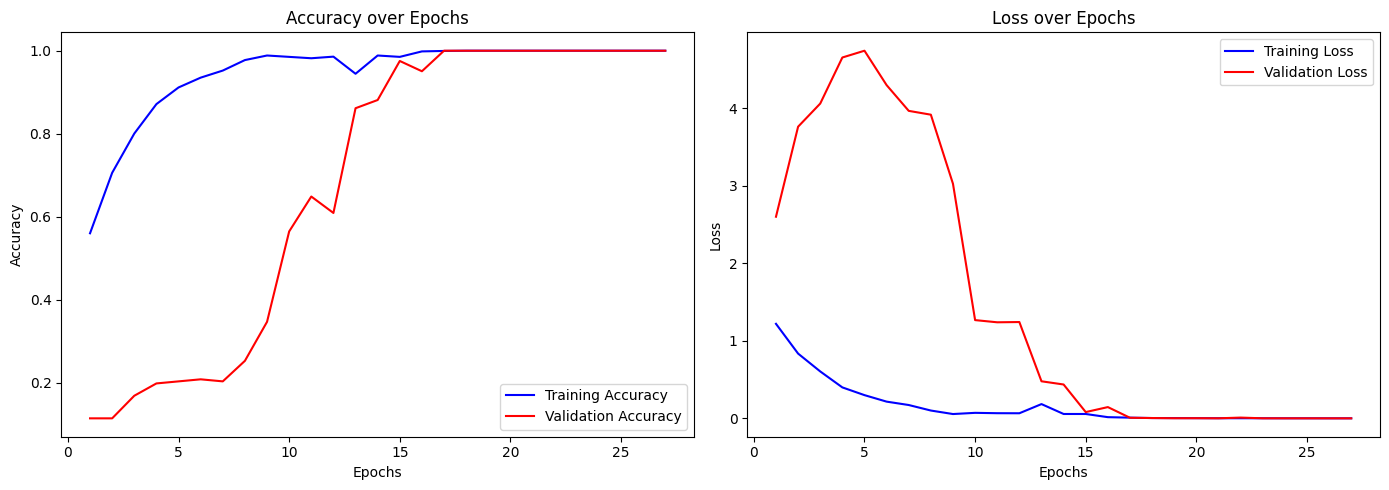

In [87]:
# Step 6A: Plot Training Accuracy and Loss

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


### Loading a Model from History

In [ ]:
# Reload history from CSV if needed
import pandas as pd

history_df = pd.read_csv(config["history_log"])
history_from_csv = {
    'accuracy': history_df['accuracy'].values,
    'val_accuracy': history_df['val_accuracy'].values,
    'loss': history_df['loss'].values,
    'val_loss': history_df['val_loss'].values
}

# Simulate a Keras History object
class FakeHistory:
    def __init__(self, history_dict):
        self.history = history_dict

plot_training_history(FakeHistory(history_from_csv))

### Evaluation and Testing

- Load the best model.
- Preprocess and pad the test data.
- Evaluate accuracy, precision, recall.
- Show a confusion matrix and classification report.

#### Pre-processing the Test Dataset

In [88]:
# Step 7A: Preprocess Test Data (pitch + duration)

# Use the pairwise loader (same as training)
test_sequences, test_labels = collect_dataset_triplet(TEST_DIR, augment=False)

# Pad to fixed sequence length
X_test = pad_sequences(test_sequences, maxlen=config["sequence_length"], padding='post', truncating='post', dtype='float32')

# Normalize all 3 features
X_test[:, :, 0] = X_test[:, :, 0] / 127.0               # pitch
X_test[:, :, 1] = np.clip(X_test[:, :, 1], 0, 5) / 5.0  # duration
X_test[:, :, 2] = X_test[:, :, 2] / 127.0               # velocity

# Encode labels using same label encoder
y_test = label_encoder.transform(test_labels)

print(f"Test shape: {X_test.shape}, Labels: {len(set(test_labels))}")


Processing chopin:   0%|          | 0/5 [00:00<?, ?it/s]/Users/falasoul/.pyenv/versions/3.10.13/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Processing schumann: 100%|██████████| 4/4 [00:00<00:00, 48.86it/s]

Test shape: (35, 1500, 3), Labels: 9


#### Loading Best Model and Prediction

In [89]:
# Step 7B: Load Best Model and Predict (pitch + duration)

best_model = tf.keras.models.load_model(config["checkpoint_path"])

# Use X_test as-is — already (samples, sequence_length, 2)
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


#### Classification Report and Confusion Matrix

🔍 Classification Report:
              precision    recall  f1-score   support

        bach       1.00      1.00      1.00         4
      bartok       1.00      0.75      0.86         4
        byrd       1.00      1.00      1.00         4
      chopin       0.67      0.50      0.57         4
      handel       0.67      0.50      0.57         4
      hummel       0.80      1.00      0.89         4
 mendelssohn       0.50      0.50      0.50         4
      mozart       0.80      1.00      0.89         4
    schumann       0.25      0.33      0.29         3

    accuracy                           0.74        35
   macro avg       0.74      0.73      0.73        35
weighted avg       0.76      0.74      0.74        35



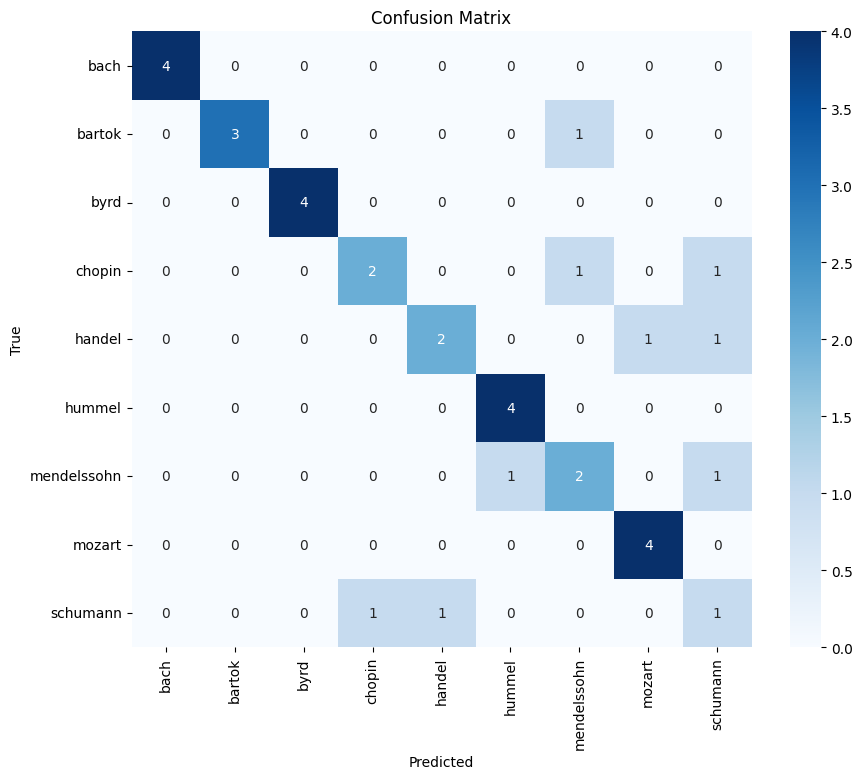

In [90]:
# Step 7C: Evaluate Model Performance

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Classification report
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### Data Augmentation via Pitch Transposition

We’ll augment each training MIDI file by shifting its note pitches up/down by a few semitones. This helps the model focus on composer style, not just pitch range.

